# Interconnect Tutorial

Sawyer B. Fuller 2023.04

### Goal: Create a single dynamic system that implements a complicated interconnected (ie, realistic) system such as the following: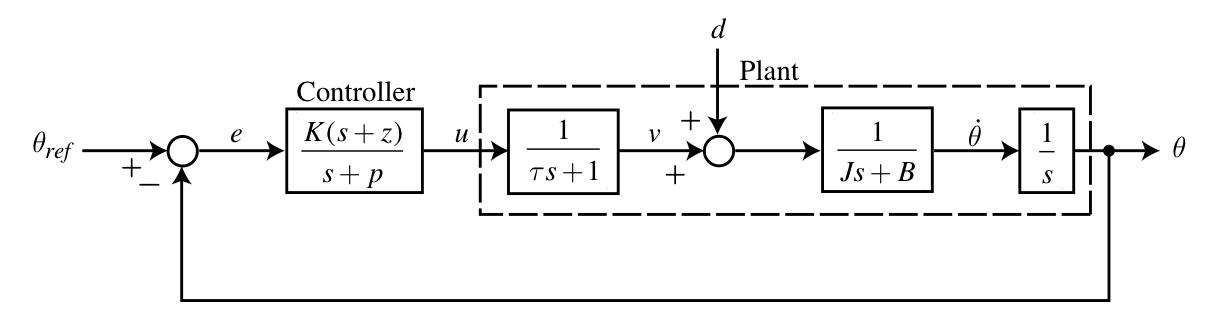

In [1]:
import numpy as np # numerical library
import matplotlib.pyplot as plt # plotting library
import control as ct # control systems library

## preliminaries

The representation of all systems in the interconnected system will be a linear, time-invariant system in state-space form given by

$\dot x = Ax + Bu$, <br>$y = Cx + Du$      

for continuous-time systems, and 

$x[k+1] = Ax[k]+Bu[k]$<br> $~~~~~~~y[k]=Cx[k]+Du[k]$ 

for discrete-time systems. $x$ is the *state*, $u$ is the *input*, and $y$ is the *output*. All of which are possibly vector-valued. 

## auto-splitting

A signal is automatically routed into every system that has an input of the same name

```
     u        y1
u  +--> sys1 --->
---|          
   +--> sys2 --->
     u        y2
```

In [2]:
# arbitrary example systems
sys1 = ct.tf(1, [10, 1], inputs='u', outputs='y1')
sys2 = ct.tf(1, [1, 0], inputs='u', outputs='y2')

# create interconnected system
interconnected = ct.interconnect([sys1, sys2], inputs='u', outputs=['y1', 'y2'])
display(interconnected) # 1-input, 2-output system

StateSpace(array([[-0.1,  0. ],
       [ 0. ,  0. ]]), array([[1.],
       [1.]]), array([[0.1, 0. ],
       [0. , 1. ]]), array([[0.],
       [0.]]))

For this system, the input has a single value $[u]$, while the output is a two-element vector $y=[y1, y2]^T$.

## auto-summing

Systems with output signals of the same name are automatically added.

```
  u1        y
---> sys1 ---+ 
             |
           + V    y
             O----->
           + ^
             |
---> sys2 ---+
  u1        y
```

In [3]:
sys1 = ct.tf(1, [10, 1], inputs='u1', outputs='y')
sys2 = ct.tf(1, [1, 0], inputs='u2', outputs='y')

# create interconnected system
interconnected = ct.interconnect([sys1, sys2], inplist=['u1', 'u2'], outlist='y')
display(interconnected) #  2-input, 1-output system

StateSpace(array([[-0.1,  0. ],
       [ 0. ,  0. ]]), array([[1., 0.],
       [0., 1.]]), array([[0.1, 1. ]]), array([[0., 0.]]))

## summing junctions

Use a summing junction to interconnect signals of different names, or to change the sign of a signal. 

```
 u      w  
---> O --->    
     ^
     | -v
     |
```

In [4]:
summer = ct.summing_junction(['u', '-v'], 'w') # w = u - v
display(summer)

StateSpace(array([], shape=(0, 0), dtype=float64), array([], shape=(0, 2), dtype=float64), array([], shape=(1, 0), dtype=float64), array([[ 1., -1.]]))

## constructing the goal system depicted above

In [5]:
# constants
K = 10
zc = 0.001 # controller zero location
pc = 2 # controller pole location
tau = 1
J = 100
b = 1

# systems
C = ct.tf([K, K*zc],[1, pc], inputs='e', outputs='u')
lopass = ct.tf(1, [tau, 1], inputs='u', outputs='v')
P = ct.tf(1, [J, b], inputs='w', outputs='thetadot')
integrator = ct.tf(1, [1, 0], inputs='thetadot', outputs='theta')
error = ct.summing_junction(['thetaref', '-theta'], 'e') # e = thetaref-theta
disturbance = ct.summing_junction(['d', 'v'], 'w') # w = d+v

# interconnect everything based on signal names
sys = ct.interconnect([C, lopass, P, integrator, error, disturbance], 
                       inputs=['thetaref', 'd'], outputs='theta')
display(sys)

StateSpace(array([[ -2.   ,   0.   ,   0.   , -10.   ],
       [ -1.999,  -1.   ,   0.   , -10.   ],
       [  0.   ,   0.1  ,  -0.01 ,   0.   ],
       [  0.   ,   0.   ,   0.1  ,   0.   ]]), array([[10. ,  0. ],
       [10. ,  0. ],
       [ 0. ,  0.1],
       [ 0. ,  0. ]]), array([[0., 0., 0., 1.]]), array([[0., 0.]]))

Finally, we can use the interconnected system just like we would use any other system object, such as computing step and frequency responses. 

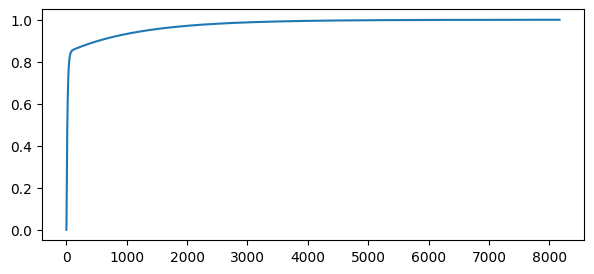

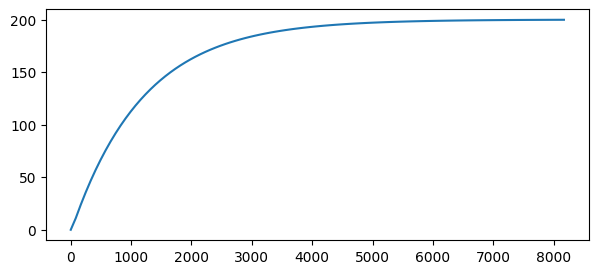

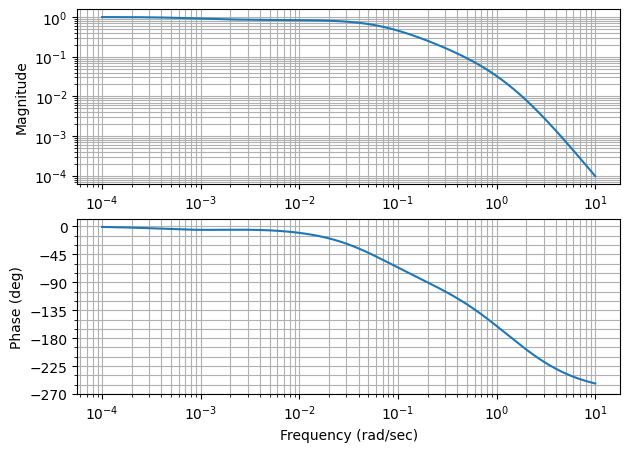

In [6]:
# extract system input-output pairs
# index order is [output, input]
plt.figure(figsize=(7,3))
sys_thetaref_to_theta = sys[0, 0] 
sys_d_to_theta = sys[0, 1]
t, y = ct.step_response(sys_thetaref_to_theta) # step response
plt.plot(t,y)
plt.figure(figsize=(7,3))
t, yd = ct.step_response(sys_d_to_theta) # disturbance response
plt.plot(t,yd);
plt.figure(figsize=(7,5))
ct.bode_plot(sys_thetaref_to_theta, plot=True);